<a href="https://colab.research.google.com/github/BruunoRangel/Planejamento-Ultrassom-/blob/main/Dataaugmentation_Pocus_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet50
from torchvision.models import resnet50
plt.ion()   # interactive mode
from PIL import Image
import random
# connect drive
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!ls 'gdrive/MyDrive/Modelo_01/data/data_pocus/'

test  train  val


In [3]:
# dataset com shape das imagens variados 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}
data_dir = 'gdrive/MyDrive/Modelo_01/data/data_pocus/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

#Loading the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Número de imagens para cada classe: ('Saudável', 790)
Número de imagens para cada classe: ('pneumonia ', 314)
Número de imagens para cada classe: ('covid', 267)


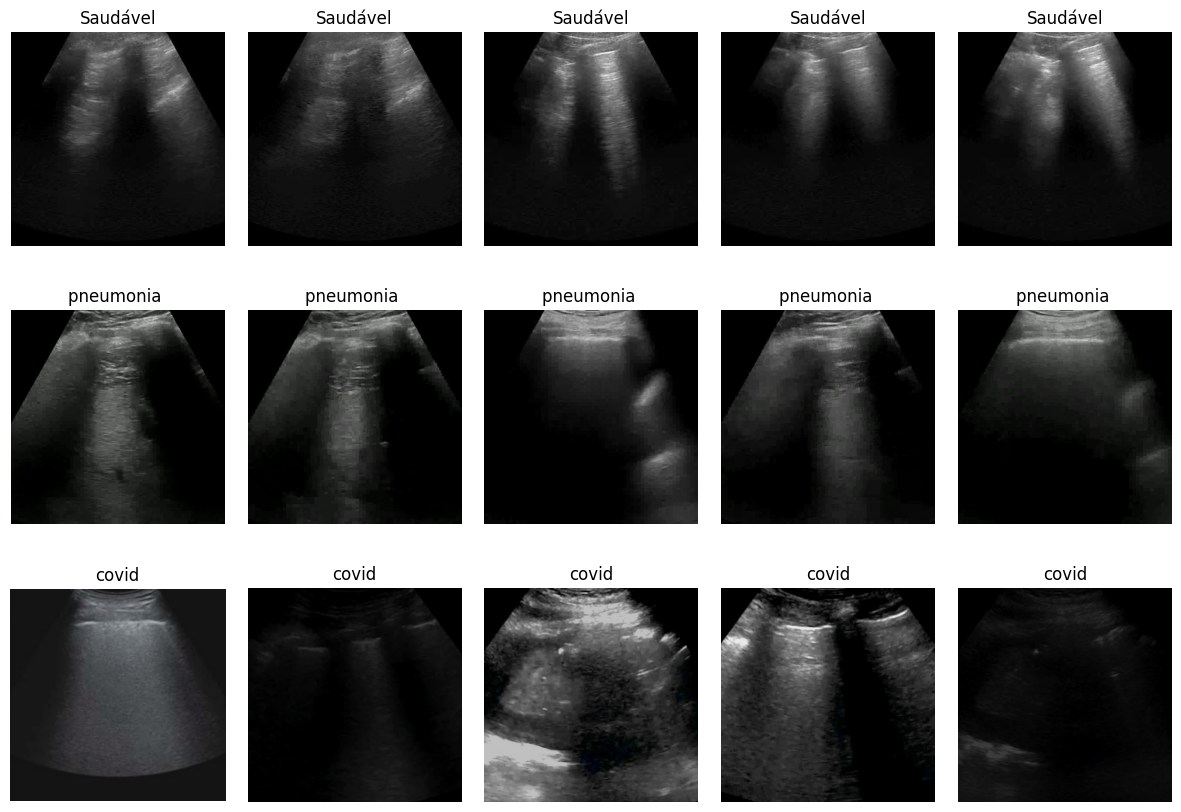

In [4]:
path = 'gdrive/MyDrive/Modelo_01/data/data_pocus/train/'

subdirs = os.listdir(path)

fig, axs = plt.subplots(len(subdirs), 5, figsize=(15, 10))
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(path, subdir)
    imgs = os.listdir(subdir_path)[:5]  # selecione os 5 primeiros arquivos de imagem
    print('Número de imagens para cada classe: ' f"{subdir,len(os.listdir(subdir_path))}")
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(subdir_path, img_name)
        img = plt.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{subdir}")
        axs[i, j].axis("off")

# Ajusta o espaçamento entre os subplots
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


Média da intensidade de pixels para Saudável: 31.61
Média da intensidade de pixels para pneumonia : 33.81
Média da intensidade de pixels para covid: 52.93


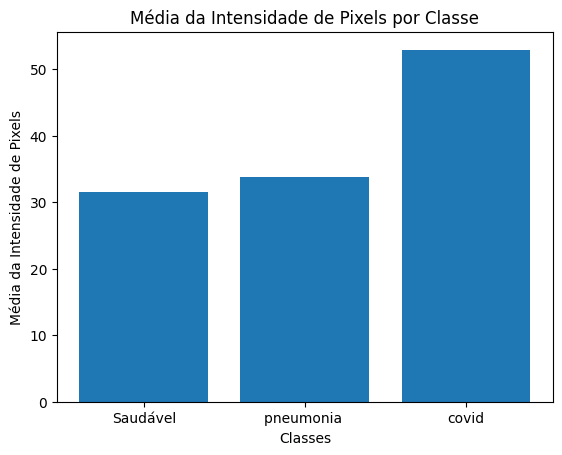

In [5]:
path = 'gdrive/MyDrive/Modelo_01/data/data_pocus/train/'
subdirs = os.listdir(path)
avg_pixel_vals = []

for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(path, subdir)
    imgs = os.listdir(subdir_path)
    avg_subdir_pixel_val = 0
    for j, img_name in enumerate(imgs):
        img_path = os.path.join(subdir_path, img_name)
        img = plt.imread(img_path)
        avg_subdir_pixel_val += np.mean(img) / len(imgs)
    avg_pixel_vals.append(avg_subdir_pixel_val)
    print(f"Média da intensidade de pixels para {subdir}: {avg_subdir_pixel_val:.2f}")

plt.bar(subdirs, avg_pixel_vals)
plt.title('Média da Intensidade de Pixels por Classe')
plt.xlabel('Classes')
plt.ylabel('Média da Intensidade de Pixels')
plt.show()

In [ ]:
#Tamanhos darasets 
print("Quantidade de imagens dataset de treino:",len(image_datasets['train']))
print("Quantidade de imagens dataset de validação:",len(image_datasets['val']))
print("Quantidade de imagens dataset de teste:",len(image_datasets['val']))

Quantidade de imagens dataset de treino: 1371
Quantidade de imagens dataset de validação: 469
Quantidade de imagens dataset de teste: 469


In [ ]:
#Quantidades de batchs em cada dataloader 
print("Quantidade de Batchs dataloader de treino:",len(dataloaders['train']))
print("Quantidade de Batchs dataloader de validação:",len(dataloaders['val']))
print("Quantidade de Batchs dataloader de teste:",len(dataloaders['test']))

Quantidade de Batchs dataloader de treino: 58
Quantidade de Batchs dataloader de validação: 20
Quantidade de Batchs dataloader de teste: 15


In [ ]:
# Conferindo os 2° batchs de treino se estão com suas dimensãoes corretas [n°de imagens, canal de cada imagem, linhas das imagens, colunas das imagens  ]
# Correto: [24,3,170,170]
c = 0 
for i in dataloaders['train']:
  print(i[0].shape)
  if c == 1:
    break
  c +=1

torch.Size([24, 3, 224, 224])
torch.Size([24, 3, 224, 224])


In [ ]:
# Check which GPU we are using
!nvidia-smi

Thu May  4 23:28:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

Batch of training data


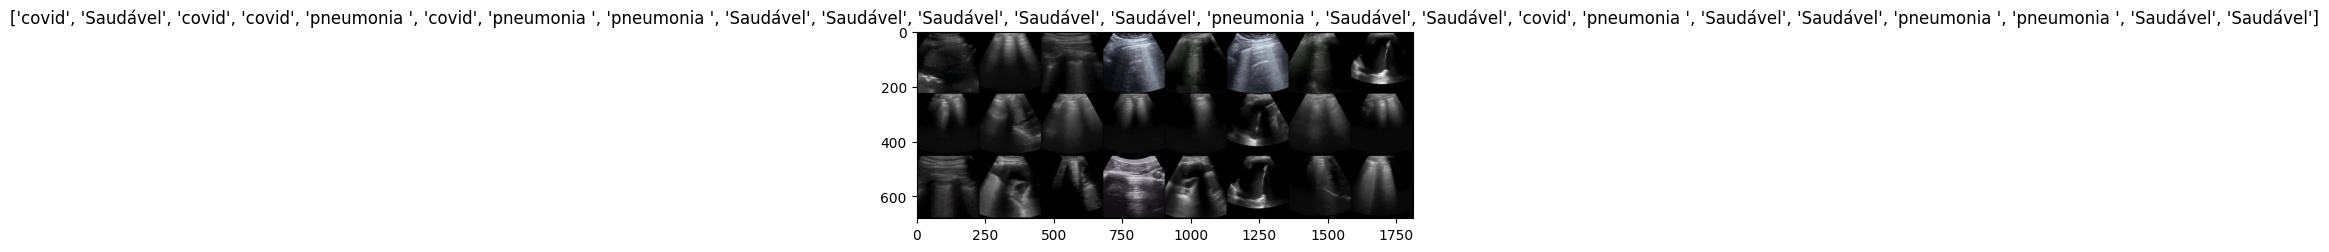

min =  0.0
median =  0.07058824
mean =  0.13573231
max =  0.9843137
Batch of validation data


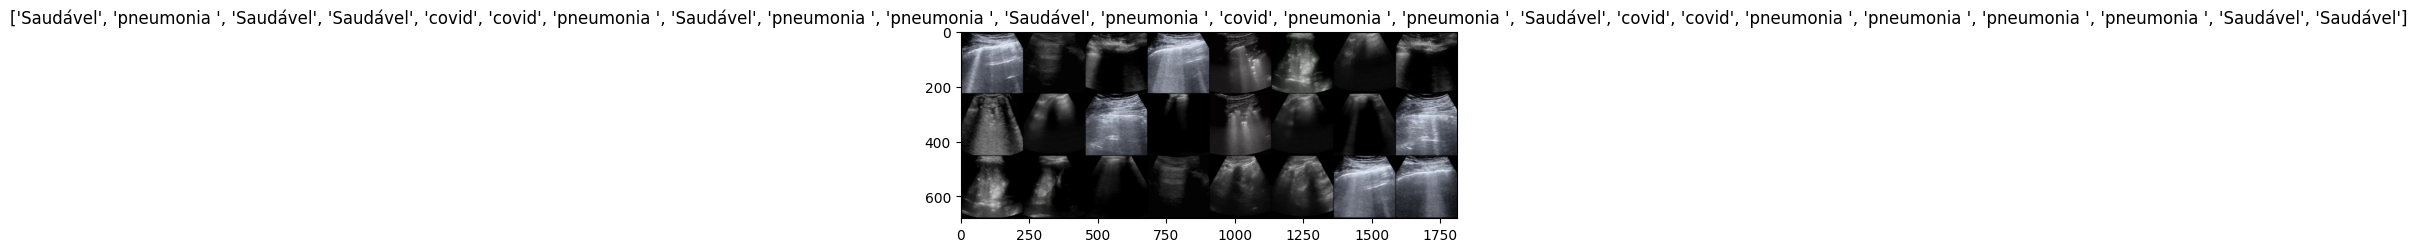

min =  0.0
median =  0.11372549
mean =  0.19203563
max =  0.99215686
Batch of test data


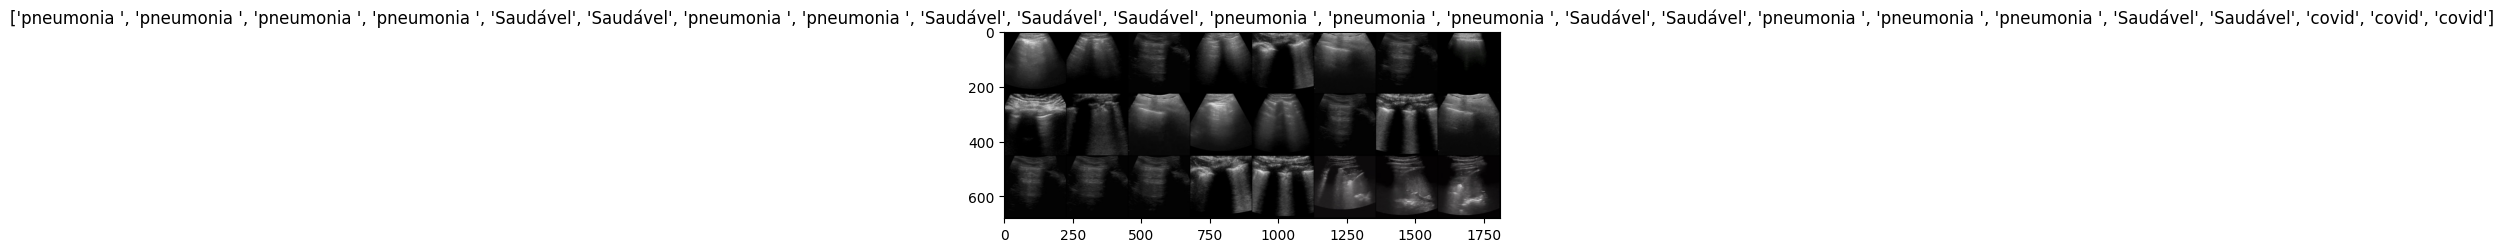

min =  0.0
median =  0.07450981
mean =  0.12983079
max =  0.96862745


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))


print('Batch of validation data')
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

print('Batch of test data')
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print('min = ', np.min(inputs.numpy()))
print('median = ', np.median(inputs.numpy()))
print('mean = ', np.mean(inputs.numpy()))
print('max = ', np.max(inputs.numpy()))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epochs.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                   
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=48bb0c8719308ee50e31101be4dbe4a54803765843b4f135db4e09fefc9ad9af
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device) #send the model to GPU if it is available or CPU otherwise

criterion = nn.CrossEntropyLoss()

optimizer_ft_randstart = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=100, gamma=0.5)

Loaded pretrained weights for efficientnet-b0


In [ ]:
# print(model) # show CNN architecture

summary(model, (3, 224, 224)) # summarize the model 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []
epochs = []

model = train_model(model, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                        num_epochs=100)

Epoch 0/99
----------
train Loss: 7.3379 Acc: 0.0029
val Loss: 7.4058 Acc: 0.0000

Epoch 1/99
----------
train Loss: 6.6943 Acc: 0.0168
val Loss: 7.6488 Acc: 0.0000

Epoch 2/99
----------
train Loss: 6.0736 Acc: 0.0751
val Loss: 7.8261 Acc: 0.0000

Epoch 3/99
----------
train Loss: 5.4427 Acc: 0.1802
val Loss: 8.0132 Acc: 0.0000

Epoch 4/99
----------
train Loss: 4.8297 Acc: 0.3115
val Loss: 8.1531 Acc: 0.0000

Epoch 5/99
----------
train Loss: 4.3136 Acc: 0.3910
val Loss: 8.1336 Acc: 0.0000

Epoch 6/99
----------
train Loss: 3.8502 Acc: 0.4435
val Loss: 7.9569 Acc: 0.0000

Epoch 7/99
----------
train Loss: 3.4817 Acc: 0.5033
val Loss: 7.7853 Acc: 0.0000

Epoch 8/99
----------
train Loss: 3.1224 Acc: 0.5653
val Loss: 7.6044 Acc: 0.0000

Epoch 9/99
----------
train Loss: 2.8280 Acc: 0.6156
val Loss: 7.3706 Acc: 0.0000

Epoch 10/99
----------
train Loss: 2.5803 Acc: 0.6565
val Loss: 7.1674 Acc: 0.0000

Epoch 11/99
----------
train Loss: 2.2571 Acc: 0.7257
val Loss: 6.9704 Acc: 0.0000

Ep

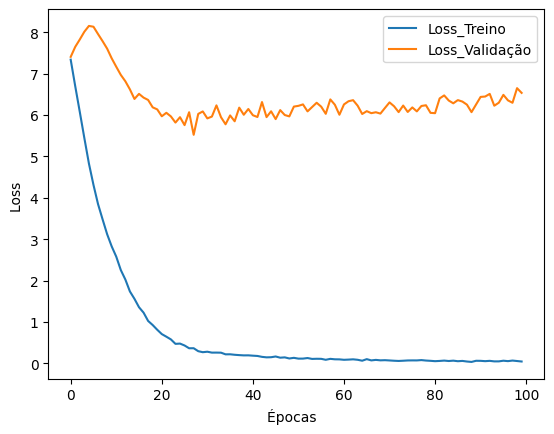

In [ ]:
LOSS_train
LOSS_val 

plt.plot(epochs,LOSS_train,)
plt.plot(epochs,LOSS_val,)
plt.legend(["Loss_Treino","Loss_Validação"])
plt.xlabel('Épocas  ')
plt.ylabel('Loss ')
plt.show()

In [ ]:
def predic_model(model, plot_img = False, num_images=24):
    was_training = model.training
    model.eval()
    images_so_far = 0
    PREDICTED = []
    LABEL = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              images_so_far += 1
              PREDICTED.append(class_names[preds[j]])
              LABEL.append(class_names[labels[j]])
              if plot_img:
                plt.figure()
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                plt.axis('off')
                plt.title('predicted: {} - label: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                plt.plot()

              if images_so_far == num_images:
                model.train(mode=was_training)
                # break
                return PREDICTED, LABEL

        model.train(mode=was_training)

    return PREDICTED, LABEL

In [ ]:
test_group_len = 26
PREDICTED, LABEL = predic_model(model, plot_img = False, num_images=test_group_len)

NameError: ignored